### **INSTALLING LIBRARY**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
!pip install skimpy
import skimpy as sk
import scipy.stats as stats
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import scale
from scipy.stats import chi2_contingency
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import requests
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score, classification_report
import yfinance as yf
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

### **DEFINING THE STOCKS, IMPORTING HISTORICAL STOCK DATA FROM YAHOO FINANCE FOR DATES STARTING FROM : 2020-01-10 TO 2024-09-26**

---



In [2]:
# Define the stock symbols
stocks = ["ONCO", "CNEY", "TNXP", "APLD", "KTTA"]

# Function to get historical stock prices from Yahoo Finance
def get_historical_prices(stocks):
    data = {}
    for stock in stocks:
        data[stock] = yf.download(stock, start="2020-01-01", end="2024-09-26")
    return data

# Fetch the historical stock prices
stock_data = get_historical_prices(stocks)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### **DEFINING A FUNCTION THAT:  FETCHES NEWS ARTICLEFOR STOCKS, PERFORMS SENTIMENT ANALYSIS, CALCULATES THE SENTIMENT SCORE AND PUT IN A DATAFRAME**

In [3]:
# Function to fetch news articles for a stock
def fetch_news(stock):
    ticker = yf.Ticker(stock)
    news = ticker.news
    return news

# Function to get sentiment data for stocks
def get_sentiment_data(stock):
    # Create a list to store sentiment scores and dates
    sentiment_scores = []

    # Define the date range
    start_date = "2020-01-01"
    end_date = "2024-09-26"
    dates = pd.date_range(start=start_date, end=end_date)

    # Fetch and analyze news for the stocks
    news_articles = fetch_news(stock)
    for article in news_articles:
        try:
            date = pd.to_datetime(article['providerPublishTime'], unit='s').date()
            if start_date <= str(date) <= end_date:
                title = article['title']
                analysis = TextBlob(title)  # Analyze news title
                sentiment_scores.append({'date': date, 'sentiment_score': analysis.sentiment.polarity})
        except KeyError as e:
            print(f"Missing key {e} in article for stock {stock}, skipping this article.")
        except Exception as e:
            print(f"Error processing article for stock {stock}: {e}")

    # Create a DataFrame from sentiment data
    sentiment_df = pd.DataFrame(sentiment_scores)

    # Aggregate sentiment scores by date
    sentiment_df = sentiment_df.groupby('date').mean()

    # Reindex to include all dates in the range
    sentiment_df = sentiment_df.reindex(dates, fill_value=0)  # Fill missing dates with 0

    return sentiment_df

### **MERGING HISTORICAL STOCK PRIZE DATA AND SENTIMENT DATA ON DATE AND PERFORMING FEATURE ENGINERRING**

In [4]:
# Collect historical prices and sentiment data for each stock
data_frames = []
historical_prices = get_historical_prices(stocks)

for stock in stocks:
    try:
        prices_df = historical_prices[stock]
        sentiment_df = get_sentiment_data(stock)

        # Check if both DataFrames are not None
        if prices_df is not None and not prices_df.empty and sentiment_df is not None and not sentiment_df.empty:
            # Merge prices and sentiment data on date
            merged_df = prices_df.merge(sentiment_df, left_index=True, right_index=True, how='left')

            # Fill missing sentiment scores with 0 (neutral sentiment)
            merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0)

            # Calculate daily price change and binary target variable
            merged_df['price_change'] = merged_df['Adj Close'].pct_change()
            merged_df['target'] = (merged_df['price_change'] > 0).astype(int)
            merged_df['moving_average_10'] = merged_df['Adj Close'].rolling(window=10).mean()
            merged_df['volatility_10'] = merged_df['Adj Close'].rolling(window=10).std()

            # Drop rows with NaN values (first row due to pct_change)
            merged_df.dropna(inplace=True)

            # Add stock symbol to the dataframe
            merged_df['stock'] = stock

            data_frames.append(merged_df)
        else:
            print(f"Data for stock {stock} could not be retrieved.")
    except Exception as e:
        print(f"Error retrieving data for stock {stock}: {e}")

# Check if there are any dataframes to concatenate
if data_frames:
    final_df = pd.concat(data_frames, ignore_index=True)
    print(final_df.head())
else:
    final_df = pd.DataFrame()  # Define an empty DataFrame if no dataframes to concatenate
    print("No dataframes to concatenate. Please check the data retrieval process.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


          Open         High          Low        Close    Adj Close  Volume  \
0  2540.000000  2540.000000  2400.000000  2460.000000  2460.000000     245   
1  2287.600098  2480.000000  1904.400024  2460.000000  2460.000000     385   
2  2386.000000  2435.600098  2386.000000  2435.600098  2435.600098      55   
3  2440.000000  2580.000000  2296.000000  2444.000000  2444.000000      73   
4  2396.000000  2600.000000  2396.000000  2600.000000  2600.000000     218   

   sentiment_score  price_change  target  moving_average_10  volatility_10  \
0              0.0     -0.023810       0        2173.700000     290.053538   
1              0.0      0.000000       0        2190.100000     302.122179   
2              0.0     -0.009919       0        2205.780005     311.170598   
3              0.0      0.003449       1        2250.980005     309.490755   
4              0.0      0.063830       1        2339.760010     261.358176   

  stock  
0  ONCO  
1  ONCO  
2  ONCO  
3  ONCO  
4  ONCO  


### **EXPLORATORY DATA ANALYSIS**

In [5]:
final_df.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment_score,price_change,target,moving_average_10,volatility_10,stock
0,2540.000000,2540.000000,2400.000000,2460.000000,2460.000000,245,0.0,-0.023810,0,2173.700000,290.053538,ONCO
1,2287.600098,2480.000000,1904.400024,2460.000000,2460.000000,385,0.0,0.000000,0,2190.100000,302.122179,ONCO
2,2386.000000,2435.600098,2386.000000,2435.600098,2435.600098,55,0.0,-0.009919,0,2205.780005,311.170598,ONCO
3,2440.000000,2580.000000,2296.000000,2444.000000,2444.000000,73,0.0,0.003449,1,2250.980005,309.490755,ONCO
4,2396.000000,2600.000000,2396.000000,2600.000000,2600.000000,218,0.0,0.063830,1,2339.760010,261.358176,ONCO


In [6]:
final_df.shape

(4092, 12)

In [7]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092 entries, 0 to 4091
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               4092 non-null   float64
 1   High               4092 non-null   float64
 2   Low                4092 non-null   float64
 3   Close              4092 non-null   float64
 4   Adj Close          4092 non-null   float64
 5   Volume             4092 non-null   int64  
 6   sentiment_score    4092 non-null   float64
 7   price_change       4092 non-null   float64
 8   target             4092 non-null   int64  
 9   moving_average_10  4092 non-null   float64
 10  volatility_10      4092 non-null   float64
 11  stock              4092 non-null   object 
dtypes: float64(9), int64(2), object(1)
memory usage: 383.8+ KB


In [8]:
final_df

,Open,High,Low,Close,Adj Close,Volume,sentiment_score,price_change,target,moving_average_10,volatility_10,stock
0,2540.000000,2540.000000,2400.000000,2460.000000,2460.000000,245,0.0,-0.023810,0,2173.700000,290.053538,ONCO
1,2287.600098,2480.000000,1904.400024,2460.000000,2460.000000,385,0.0,0.000000,0,2190.100000,302.122179,ONCO
2,2386.000000,2435.600098,2386.000000,2435.600098,2435.600098,55,0.0,-0.009919,0,2205.780005,311.170598,ONCO
3,2440.000000,2580.000000,2296.000000,2444.000000,2444.000000,73,0.0,0.003449,1,2250.980005,309.490755,ONCO
4,2396.000000,2600.000000,2396.000000,2600.000000,2600.000000,218,0.0,0.063830,1,2339.760010,261.358176,ONCO
...,...,...,...,...,...,...,...,...,...,...,...,...
4087,6.280000,6.299000,4.623000,4.800000,4.800000,66400,0.0,-0.172414,0,4.313500,0.616973,KTTA
4088,4.680000,4.800000,4.420000,4.420000,4.420000,9400,0.0,-0.079167,0,4.336500,0.616144,KTTA
4089,4.420000,4.700000,4.100000,4.100000,4.100000,7800,0.0,-0.072398,0,4.321500,0.620296,KTTA
4090,4.110000,4.315000,3.835000,3.963000,3.963000,90600,0.0,-0.033415,0,4.328800,0.615061,KTTA


In [9]:
final_df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
sentiment_score,0
price_change,0
target,0
moving_average_10,0


In [10]:
final_df.duplicated().sum()

0

In [11]:
final_df['stock'].value_counts()

,count
stock,
TNXP,1182
CNEY,906
KTTA,753
ONCO,644
APLD,607


In [12]:
final_df = final_df.rename(columns={'Adj Close': 'adjusted_close'})

In [13]:
final_df.columns

Index(['Open', 'High', 'Low', 'Close', 'adjusted_close', 'Volume',
       'sentiment_score', 'price_change', 'target', 'moving_average_10',
       'volatility_10', 'stock'],
      dtype='object')

1.   **price_change:** This represents the percentage change in the stock’s adjusted closing price from one day to the next.This feature has the highest importance score, indicating it is the most influential in your model.

2.   **Close:** The closing price of the stock on a given trading day. This is the final price at which the stock traded when the market closed.

3.  **Volume:** The total number of shares traded during a given trading day. High volume can indicate strong investor interest in the stock.

4. **Open:** The opening price of the stock on a given trading day. This is the price at which the stock first traded when the market opened.

5. **adjusted_close:** The closing price of the stock adjusted for corporate actions such as dividends, stock splits, and new stock offerings. This provides a more accurate reflection of the stock’s value over time.

6. **Low:** The lowest price at which the stock traded during a given trading day.
7. **High:** The highest price at which the stock traded during a given trading day.
8. **Moving_avaerage:** It helps smooth out short-term price fluctuations and identify the overall trend of the stock's price over the 10-day period. A rising moving average suggests an upward trend, while a falling moving average indicates a downward trend.
9. **Volatility:** It measures the price fluctuations or the degree of price variation over the 10-day period. Higher values indicate greater price volatility, suggesting a riskier investment, while lower values suggest a more stable price.


In [14]:
final_df['target'].value_counts()

,count
target,
0,2457
1,1635


### **Chi-squared:**  **Checking for relationship between stock and target variable in final_df**

In [15]:
# Perform Chi-squared test for independence between 'stock' and 'target'
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(final_df['stock'], final_df['target'])

# Perform the Chi-squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

# Interpret the results
alpha = 0.05  # Significance level
if p_val < alpha:
    print("There is a significant relationship between stock and target variable.")
else:
    print("There is no significant relationship between stock and target variable.")

Chi-squared statistic: 35.67052030947297
P-value: 3.3823344932882327e-07
Degrees of freedom: 4
Expected frequencies: [[364.4670088  242.5329912 ]
 [543.99853372 362.00146628]
 [452.13123167 300.86876833]
 [386.68328446 257.31671554]
 [709.71994135 472.28005865]]
There is a significant relationship between stock and target variable.


### **EXPLORING ASSOCIATION OF CATEGORICAL VARIABLE WITH TARGET**

In [16]:
# Ensure 'stock' is a single categorical feature in your DataFrame
if 'stock' in final_df.columns:
    unique_stocks = final_df['stock'].unique()

    for stock in unique_stocks:
        # Create a binary variable for the current stock
        final_df[f'is_{stock}'] = final_df['stock'] == stock

        # Create a contingency table
        contingency_table = pd.crosstab(final_df[f'is_{stock}'], final_df['target'])

        # Ensure the contingency table has the correct shape
        if contingency_table.shape == (2, 2):
            # Calculate odds ratio
            odds_ratio = (contingency_table.iloc[0, 0] * contingency_table.iloc[1, 1]) / (contingency_table.iloc[0, 1] * contingency_table.iloc[1, 0])

            # Print the result
            print(f"Odds ratio for {stock}:", odds_ratio)
        else:
            print(f"Contingency table for {stock} does not have the expected shape (2, 2).")
else:
    print(f"Feature 'stock' not found in DataFrame 'final_df'.")


Odds ratio for ONCO: 0.8471807593659336
Odds ratio for CNEY: 1.151200960768615
Odds ratio for TNXP: 0.7533633055387179
Odds ratio for APLD: 1.513526119402985
Odds ratio for KTTA: 1.0076998185244759


**Stock_APLD: 1.5135:** Holding stock_APLD is associated with a 51.35% higher odds of a price increase.

**Stock_CNEY:** 1.1512: Holding stock_CNEY is associated with a 15.12% higher odds of a price increase.

**Stock_KTTA: 1.0077:** Holding stock_KTTA has a very slight positive association with a price increase, almost neutral.

**Stock_ONCO:** 0.8472: Holding stock_ONCO is associated with a 15.28% lower odds of a price increase.

**Stock_TNXP:** 0.7534: Holding stock_TNXP is associated with a 24.66% lower odds of a price increase.




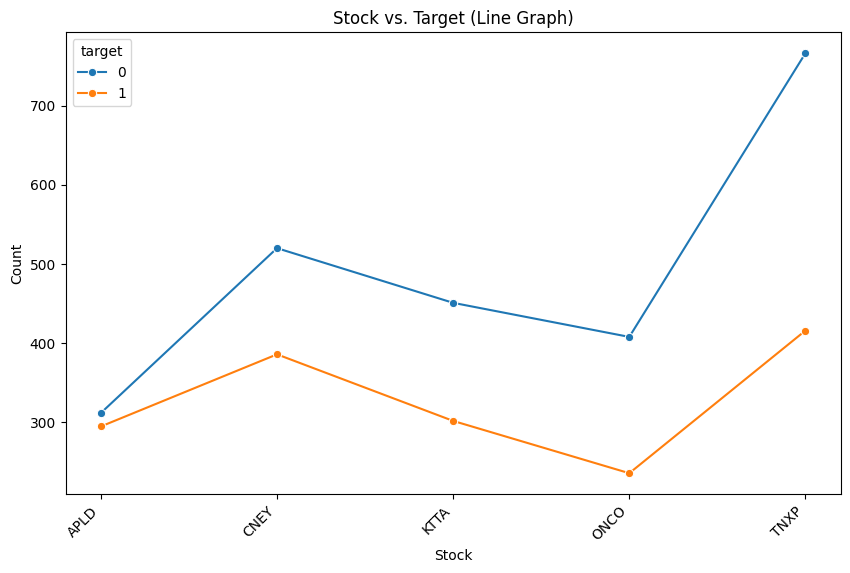

In [17]:
# Group data by stock and target, and calculate the count
stock_target_counts = final_df.groupby(['stock', 'target'])['target'].count().reset_index(name='count')

# Plot the line graph
plt.figure(figsize=(10, 6))
sns.lineplot(x='stock', y='count', hue='target', data=stock_target_counts, marker='o')
plt.title("Stock vs. Target (Line Graph)")
plt.xlabel("Stock")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

**Risk Assessment Insight:**

*  **Higher Risk:** Stocks with more frequent price decreases like **"TNXP"**, **"KTTA"**,and **"ONCO"** might be considered higher risk. Investors should assess their risk tolerance before investing.

*  **Volatility:** These stocks might be more volatile, leading to potential short-term trading opportunities but also higher risk.

### **Relationship between numerical features in the dataset**

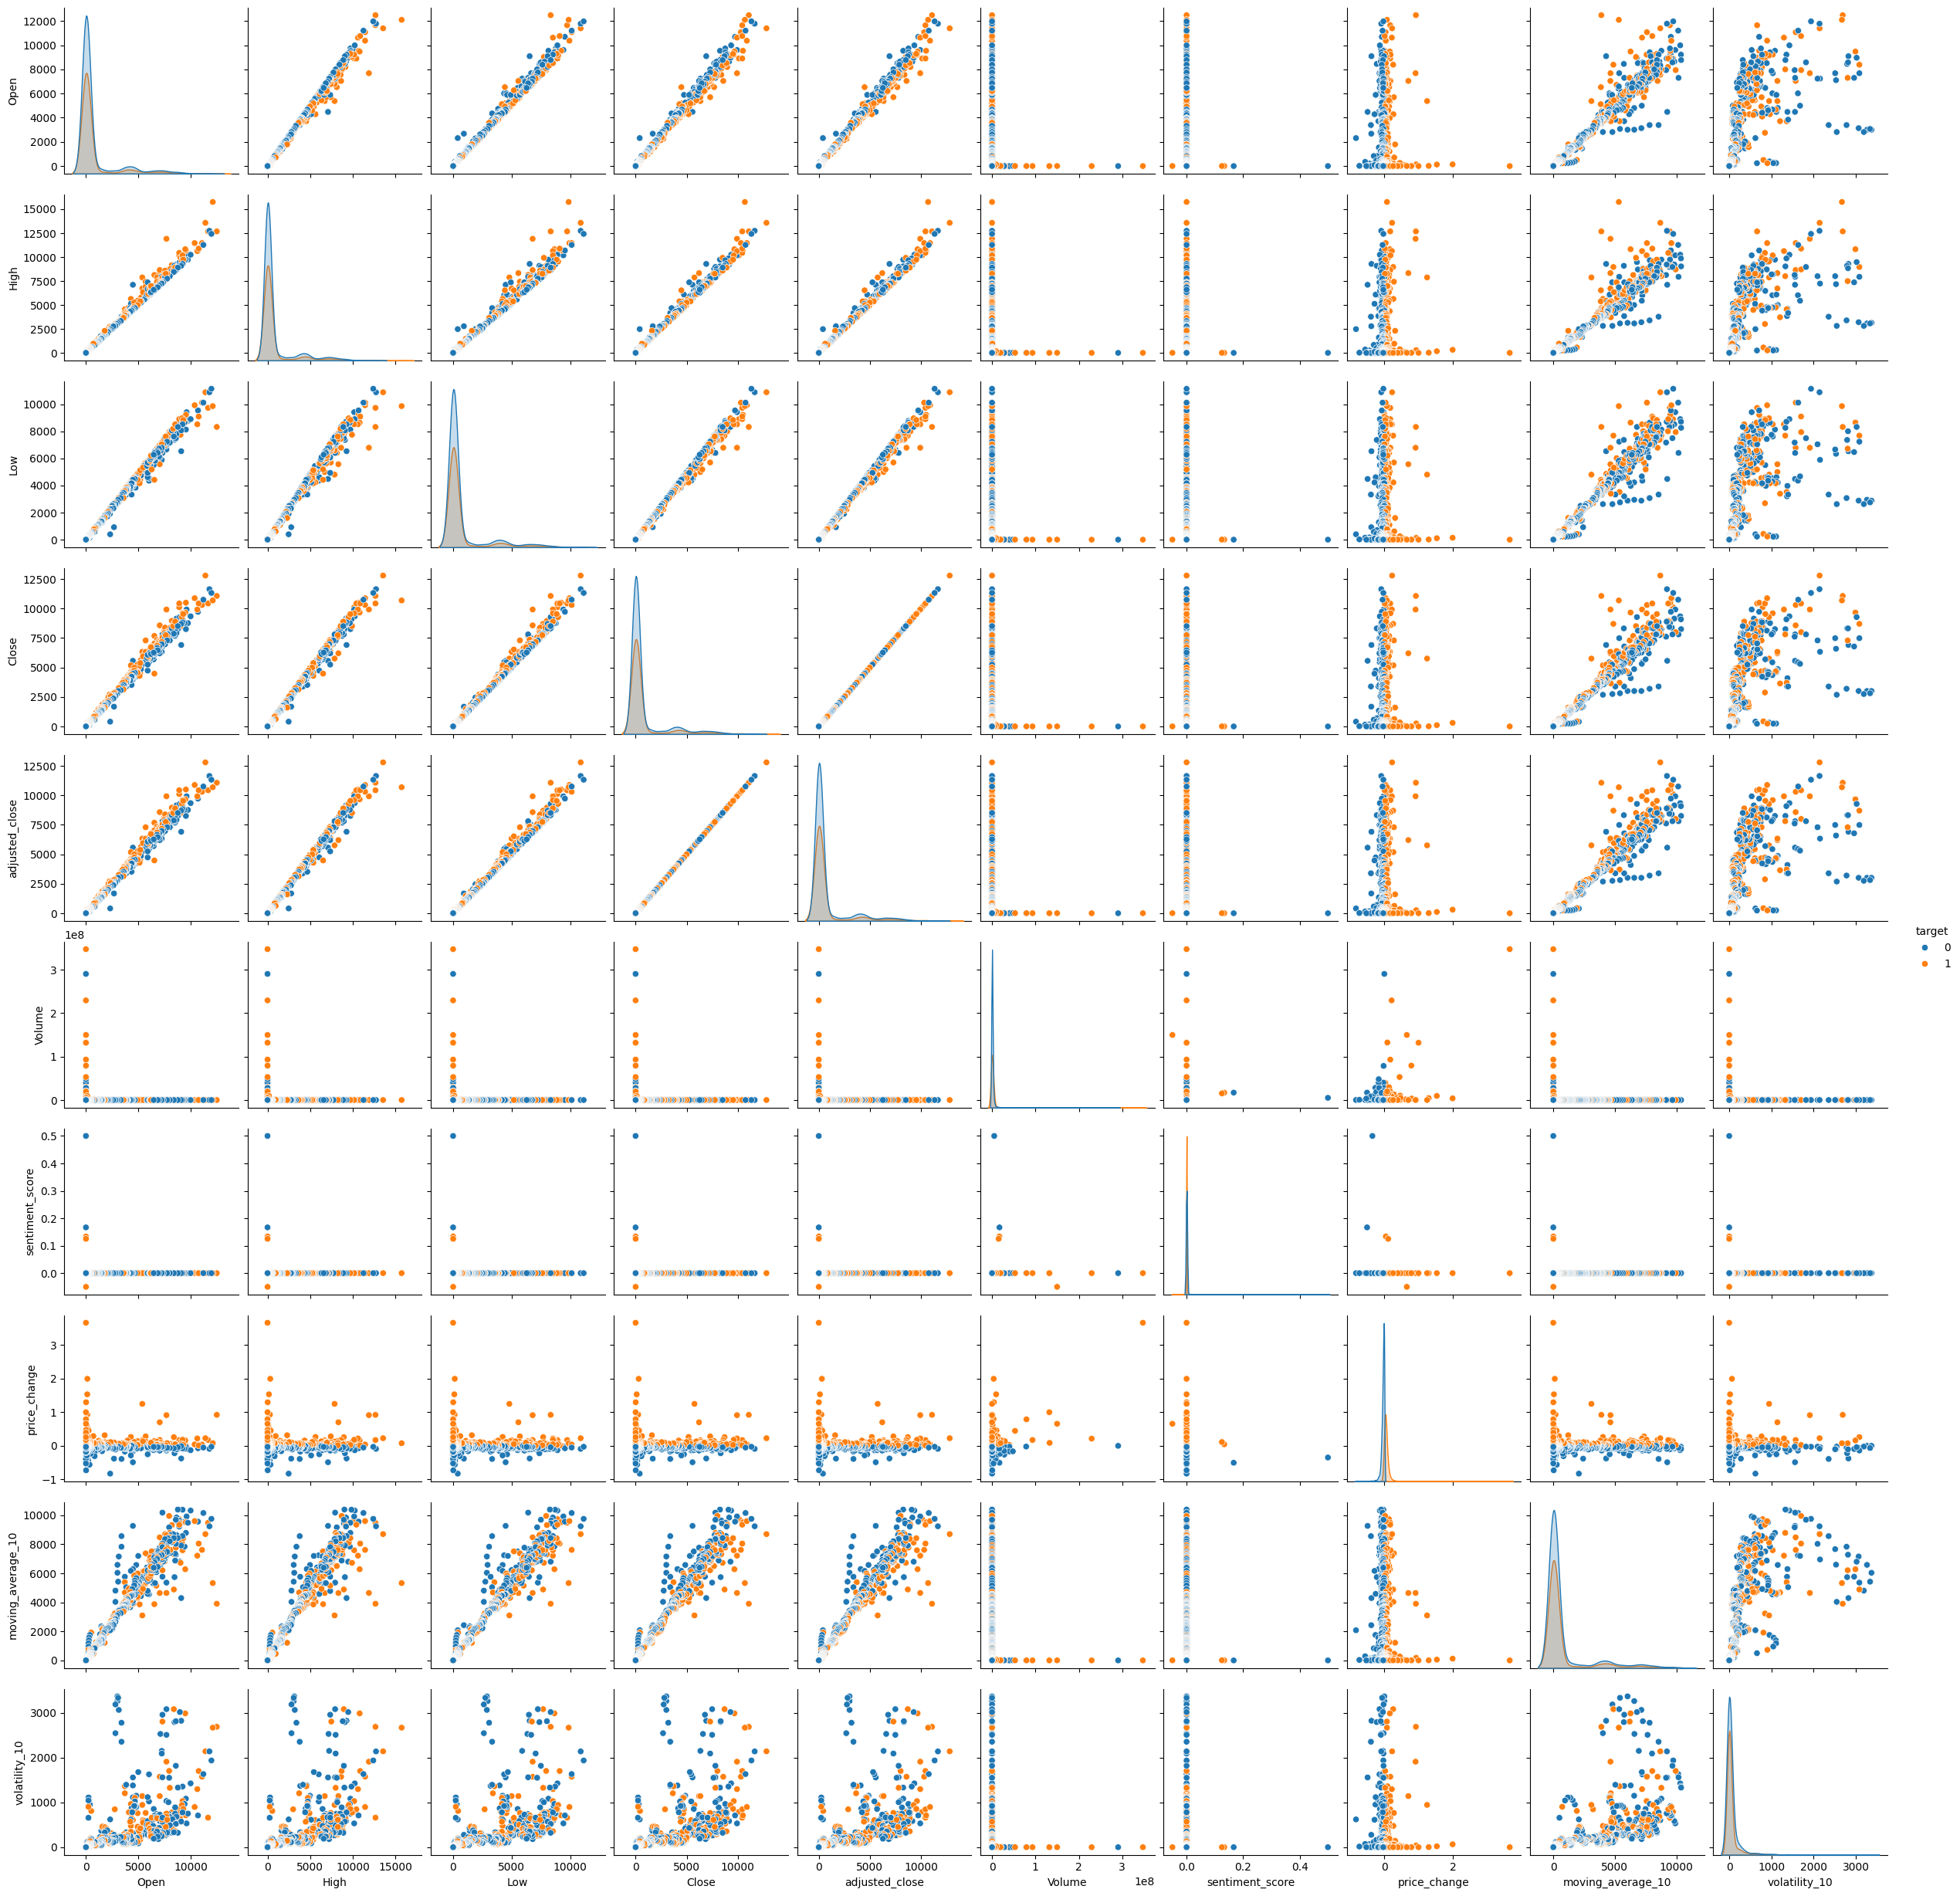

In [18]:
# Select numerical features for the pairplot
numerical_features = ['Open', 'High', 'Low', 'Close', 'adjusted_close', 'Volume', 'sentiment_score', 'price_change', 'moving_average_10', 'volatility_10']

# Create the pairplot
sns.pairplot(final_df, hue='target', vars=numerical_features)
plt.show()

**INSIGHTS**:

**Strong positive correlation:** There is a strong positive correlation between 'Open', 'High', 'Low', 'Close', and 'adjusted_close'. As one feature increases, the other also tends to increase. (This correlation can be useful for predictive modeling. For example, if you know the opening price, you can reasonably predict the closing price. It also suggests that these features might be redundant in some models, and I may just use one or a combination of them to reduce multicollinearity.)

**Relationship with target:** Price_change' is skewed differently for stocks with a target value of 1 (price increase) compared to stocks with a target value of 0 (price decrease). (This finding can be leveraged in classification models to predict whether the stock price will increase or decrease. Understanding the distribution of price changes can help in setting thresholds or in feature engineering to improve model accuracy.)

**Outliers:** There are outliers with high or low trading volumes ('Volume').(Identifying and analyzing these outliers can provide insights into market behavior and investor sentiment.)

### **CHECKING FOR SKEWS**

In [19]:
from scipy.stats import skew

# Calculate skewness of the target variable
target_skewness = skew(final_df['target'])

# Print the result
print("Skewness of target variable:", target_skewness)

Skewness of target variable: 0.4101194448250987


/tmp/ipykernel_10044/1005728842.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(final_df[final_df['target'] == 1]['price_change'], label='Target = 1 (Price Increase)', shade=True)
/tmp/ipykernel_10044/1005728842.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(final_df[final_df['target'] == 0]['price_change'], label='Target = 0 (Price Decrease)', shade=True)


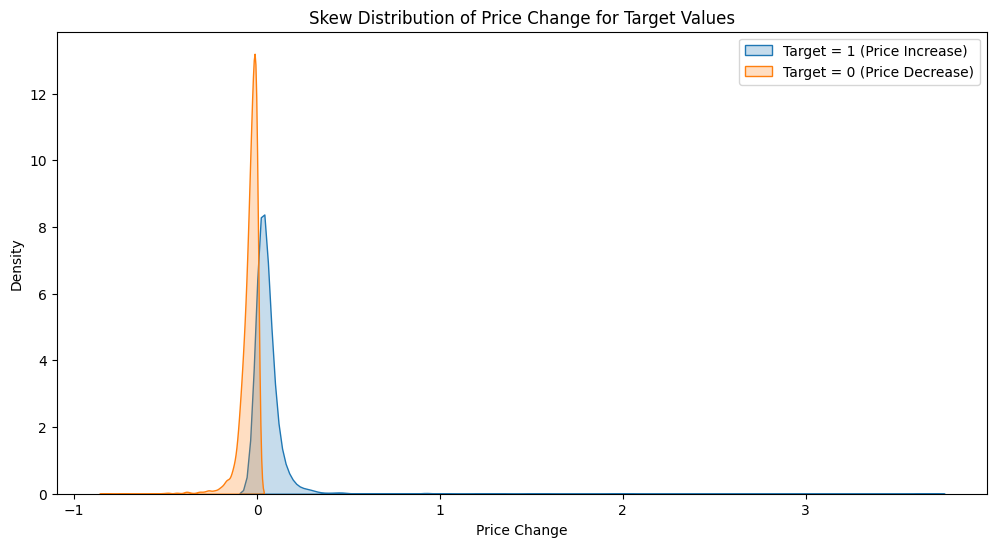

In [20]:
# Plot the skew distribution of 'price_change' for stocks with target value 1 and 0
plt.figure(figsize=(12, 6))

# Distribution for target value 1 (price increase)
sns.kdeplot(final_df[final_df['target'] == 1]['price_change'], label='Target = 1 (Price Increase)', shade=True)

# Distribution for target value 0 (price decrease)
sns.kdeplot(final_df[final_df['target'] == 0]['price_change'], label='Target = 0 (Price Decrease)', shade=True)

plt.title('Skew Distribution of Price Change for Target Values')
plt.xlabel('Price Change')
plt.ylabel('Density')
plt.legend()
plt.show()

### **CORRELATION HEAT FOR CORRELATION BETWEEN NUMERICAL FEATURES**

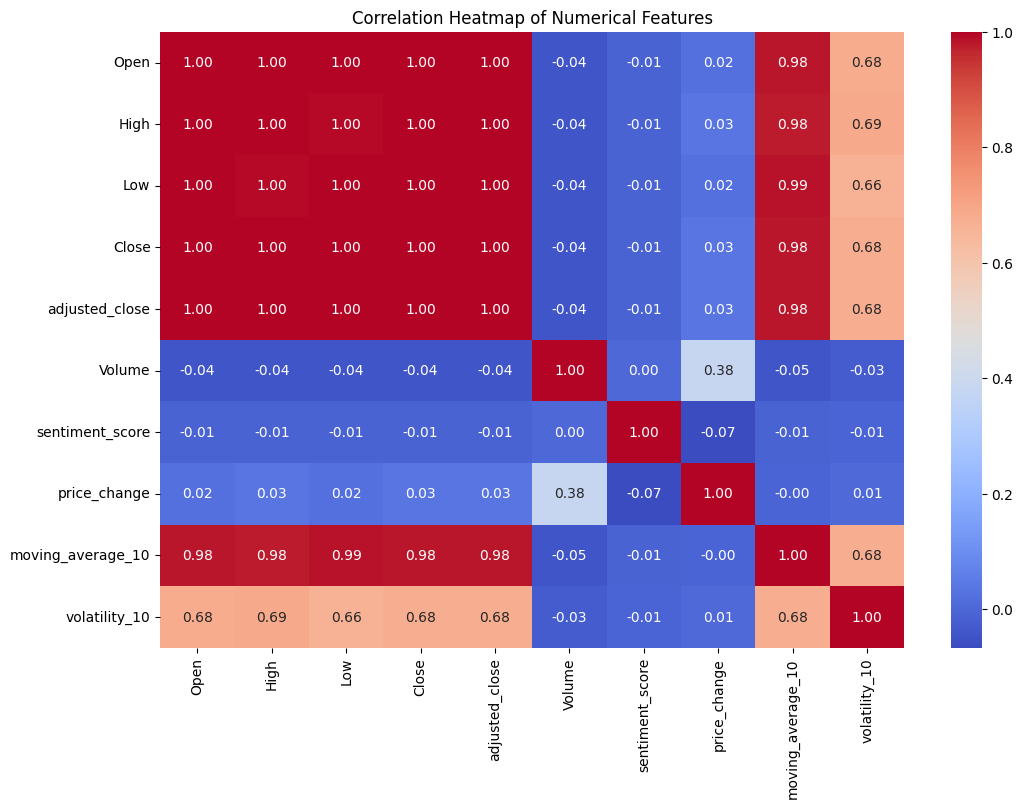

In [21]:
# Select numerical features
numerical_features = ['Open', 'High', 'Low', 'Close', 'adjusted_close', 'Volume', 'sentiment_score', 'price_change', 'moving_average_10', 'volatility_10']

# Calculate correlation matrix
correlation_matrix = final_df[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


These numerical features **'Open', 'High', 'Low', 'Close', 'adjusted_close', 'moving_average_10'** show a strong positive correlation. This can introduce redundancy or multicolineraity.

for effectiveness of the machine language model we will consider dropping **'High', 'Low', 'Close', 'adjusted_close'**


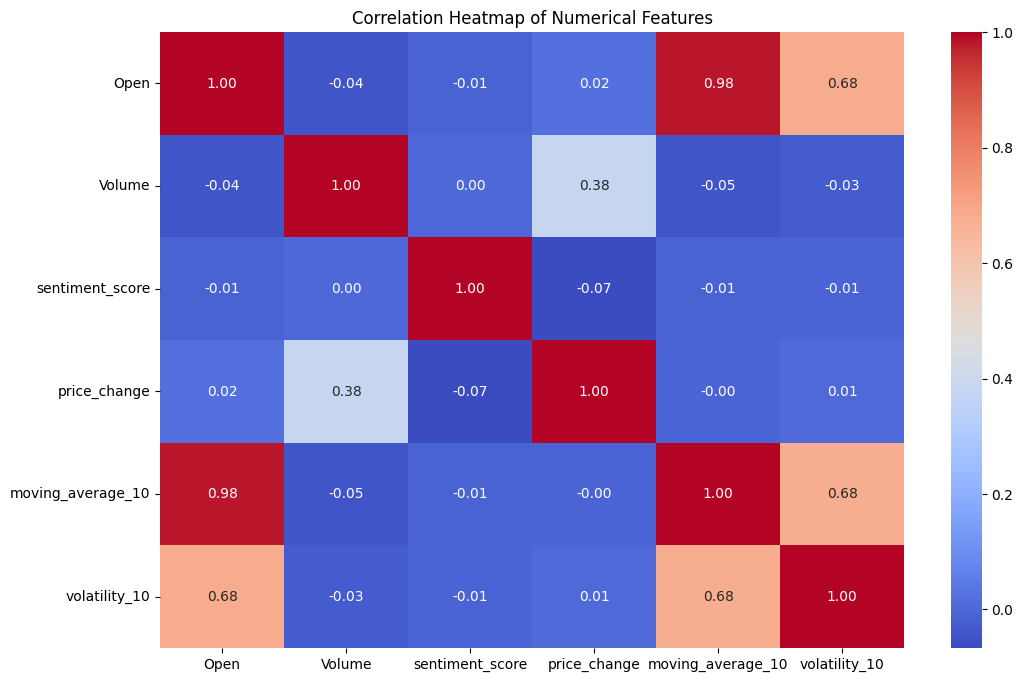

In [22]:
# Select numerical features
numerical_features_1 = ['Open', 'Volume', 'sentiment_score', 'price_change', 'moving_average_10', 'volatility_10']

# Calculate correlation matrix
correlation_matrix_1 = final_df[numerical_features_1].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size if needed
sns.heatmap(correlation_matrix_1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

**RANDOM FOREST MODEL**

In [23]:
# Define features and target variable
features = ['Open', 'Volume','sentiment_score', 'price_change', 'moving_average_10','volatility_10', 'stock']
# Assuming 'final_df' is your DataFrame and 'features' is a list of feature names
categorical_features = [feature for feature in features if final_df[feature].dtype == 'object']

# Create dummy variables for categorical features only
x = pd.get_dummies(final_df[features], columns=categorical_features)
y = final_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9987789987789988
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       490
           1       1.00      1.00      1.00       329

    accuracy                           1.00       819
   macro avg       1.00      1.00      1.00       819
weighted avg       1.00      1.00      1.00       819



In [24]:
y_probs =clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

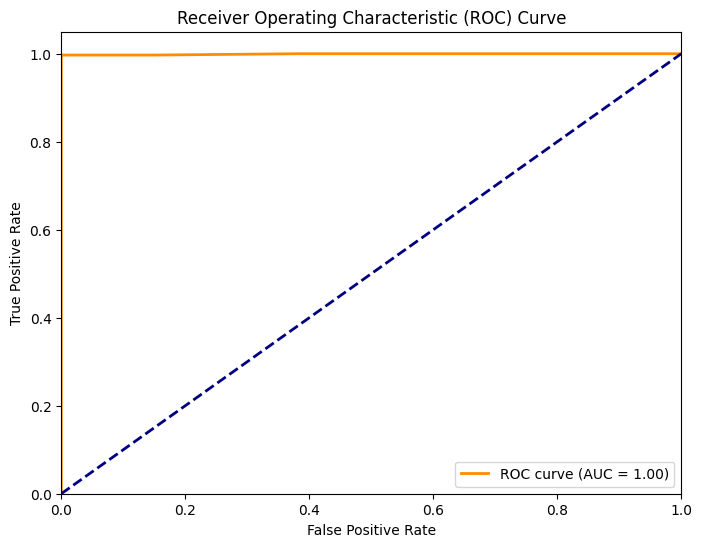

In [25]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Model Evaluation**

**Accuracy:** 0.9987789987789988: This means that the model correctly predicted the target variable for approximately 99.88% of the instances in the dataset.

**Precision:** Based on precision 1 that means all instances predicted as class 0 were actually class 0, and all instances predicted as class 1 were actually class 1.

**Recall: 1.00:** All actual class 0 instances were correctly predicted, and all actual class 1 instances were correctly predicted.

**F1-Score: 1.00:** it means that there is perfect balance between precision and recall.

**Interpretation**
The model is performing exceptionally well, with near-perfect precision, recall, and F1-scores for both classes. This indicates that the model is highly accurate in predicting both price increases (class 1) and price decreases (class 0).

In [26]:
importances = clf.feature_importances_
importances_df = pd.DataFrame({'Feature': x.columns, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df

,Feature,Importance
3,price_change,0.970060
1,Volume,0.008211
4,moving_average_10,0.006365
0,Open,0.006162
5,volatility_10,0.005953
10,stock_TNXP,0.000944
6,stock_APLD,0.000907
9,stock_ONCO,0.000652
7,stock_CNEY,0.000476
8,stock_KTTA,0.000165


**Interpretation**
*  **price_change:** being the most important feature suggests that recent price changes are the strongest indicator for THE target variable.

* **Features like:** **Volume, Moving_average_10, Open and Volatility_10** still play a role but are much less influential.

* **The specific stocks and sentiment_score** have very low importance, indicating they have little or no impact on the model’s predictions.

**OVERALL:**

Stock features like **closing price from one day to the next (Price_change)**, **number of shares traded during a given trading day (Volume)**, **average stock price performance over days (Moving_average_10)** **stock Opening price (Open)** and **Price fluctuation over 10 days (Volatility_10)** plays a role effectively determine if the stock price will increase or decrease